# Forecast Maximum Rainfall 

## Import Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from pprint import pprint

from ts.utility import Utility
from ts.experimental import GeneralizedExtremeValueDistribution, GevEstimate, Pso
from ts.decompose import StlDecompose

## Load Dataset

In [2]:
rainfall_df = pd.read_csv('../datasets/rainfall-data.csv')[['YEAR', 'MN', 'DT', '..R/F']]
rainfall_df

,YEAR,MN,DT,..R/F
0,1970,1,1,0.0
1,1970,1,2,3.2
2,1970,1,3,0.0
3,1970,1,4,0.0
4,1970,1,5,0.0
...,...,...,...,...
17647,2018,4,26,0.0
17648,2018,4,27,2.1
17649,2018,4,28,0.0
17650,2018,4,29,0.0


### Plot Entire Data

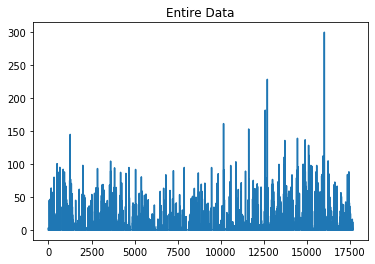

In [3]:
plt.plot(rainfall_df['..R/F'].to_numpy())
plt.title('Entire Data')
plt.show()

## Computing Monthly Rainfall

Data Type: float64, Data Shape: (580,)

First 10 data points:
[3.2, 45.0, 0.0, 47.0, 25.2, 63.6, 39.0, 57.0, 27.0, 30.0]

Last 10 data points:
[58.0, 54.2, 88.2, 41.1, 15.2, 24.8, 0.0, 12.6, 14.8, 16.2]


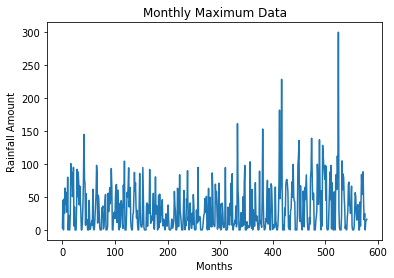

In [4]:
month_max_series = [rainfall_df.iloc[0]['..R/F']]
prev_month = rainfall_df.iloc[0]['MN']

for _, row in rainfall_df.iloc[1:].iterrows():
    
    if row['MN'] == prev_month:
        month_max_series[-1] = max(month_max_series[-1], row['..R/F'])
        
    else:
        month_max_series.append(row['..R/F'])
        
    prev_month = row['MN']
    
month_max_series = np.array(month_max_series)

print(f'Data Type: {month_max_series.dtype}, Data Shape: {month_max_series.shape}\n')
print('First 10 data points:')
pprint(list(month_max_series[:10]))
print('')

print('Last 10 data points:')
pprint(list(month_max_series[-10:]))

plt.plot(month_max_series)
plt.title('Monthly Maximum Data')
plt.xlabel('Months')
plt.ylabel('Rainfall Amount')
plt.show()

## Decompose the time series into trend, seasonality and remainder components

In [5]:
trend_series, seasonality_series, remainder_series = StlDecompose\
    .decompose(np.expand_dims(month_max_series, axis=1), 
        period=12, seasonal=101, robust=True)

assert trend_series.shape == seasonality_series.shape == remainder_series.shape

### Plot Time Series Components

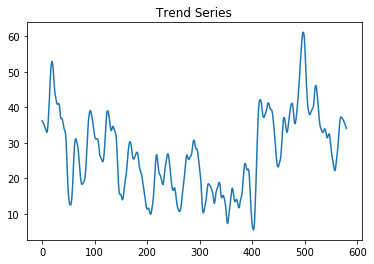

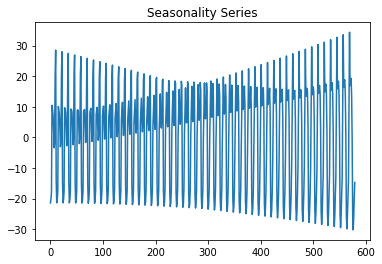

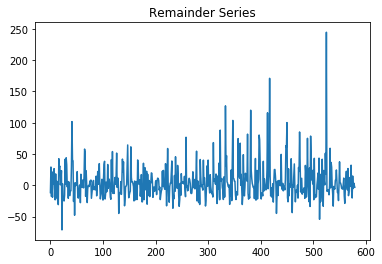

In [6]:
plt.plot(trend_series)
plt.title('Trend Series')
plt.show()

plt.plot(seasonality_series)
plt.title('Seasonality Series')
plt.show()

plt.plot(remainder_series)
plt.title('Remainder Series')
plt.show()

### Compare the inferred seasonality with actual data

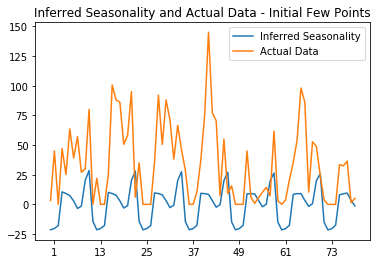

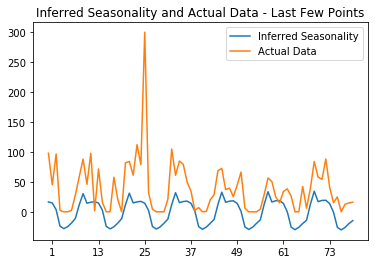

In [7]:
# Front Few Points
num_initial_points = 80

plt.plot(seasonality_series[:num_initial_points], label='Inferred Seasonality')
plt.plot(month_max_series[:num_initial_points], label='Actual Data')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Initial Few Points')
plt.xticks(np.arange(1, num_initial_points, 12))
plt.show()

# Last Few Points
num_last_points = 80

plt.plot(seasonality_series[-num_last_points:], label='Inferred Seasonality')
plt.plot(month_max_series[-num_last_points:], label='Actual Data')
plt.legend()
plt.title('Inferred Seasonality and Actual Data - Last Few Points')
plt.xticks(np.arange(1, num_last_points, 12))
plt.show()

## Parameter Estimation of GEV fitted to Remainder Series

### Fitting GEV parameters using PSO to remainder series

Shape Parameter: -0.009297857415973587 
Location Parameter: -6.466789738977299 
Scale Parameter: 20.806597598067974 
Log Likelihood: -2660.618085806681


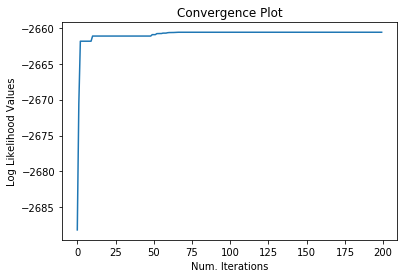

In [8]:
params, max_log_likelihood, max_log_likelihood_vals = GevEstimate.psoMethod(
    remainder_series,
    Pso.computeInitialPos([(-10, 10), (-10, 10), (5, 30)], 200),
    numIterations=200
)

shape, location, scale = params
print(f'Shape Parameter: {shape} \n'
    + f'Location Parameter: {location} \n'
    + f'Scale Parameter: {scale} \n'
    + f'Log Likelihood: {max_log_likelihood}')

plt.plot(max_log_likelihood_vals)
plt.title('Convergence Plot')
plt.xlabel('Num. Iterations')
plt.ylabel('Log Likelihood Values')
plt.show()

In [9]:
gev_dist = GeneralizedExtremeValueDistribution(*tuple(params))

### Plot PDF and CDF

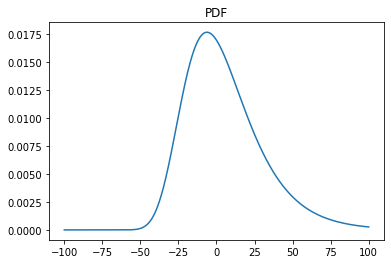

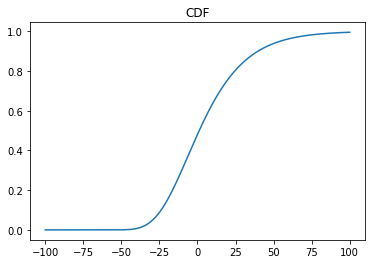

In [10]:
x = np.linspace(-100, 100, 10000)

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).pdf(x)
)
plt.title('PDF')
plt.show()

plt.plot(
    x, GeneralizedExtremeValueDistribution(
        params[0], params[1], params[2]
    ).cdf(x)
)
plt.title('CDF')
plt.show()

## Compute CDF of each data point in remainder series

Data Type: float64, Data Shape: (580, 1)

First 5 data points:
array([[0.2785786 ],
       [0.83782778],
       [0.17888047],
       [0.49895115],
       [0.1612995 ]])

Last 5 data points:
array([[0.70057799],
       [0.39164451],
       [0.54158101],
       [0.48044212],
       [0.42682192]])


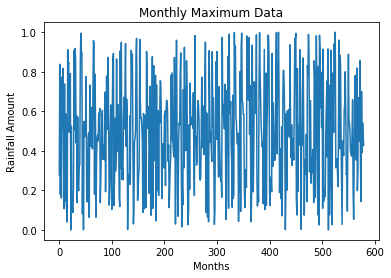

In [11]:
remainder_series_cdf = gev_dist.cdf(remainder_series)

print(f'Data Type: {remainder_series_cdf.dtype}, Data Shape: {remainder_series_cdf.shape}\n')
print('First 5 data points:')
pprint(remainder_series_cdf[:5])
print('')

print('Last 5 data points:')
pprint(remainder_series_cdf[-5:])

plt.plot(remainder_series_cdf)
plt.title('Monthly Maximum Data')
plt.xlabel('Months')
plt.ylabel('Rainfall Amount')
plt.show()

## Train and Test Data

In [12]:
train_frac = 0.85
num_train = int(trend_series.shape[0] * train_frac)

# trend series
train_trend_series = trend_series[:num_train]

# seasonality series
train_seasonality_series = seasonality_series[:num_train]

# remainder series
train_remainder_series = remainder_series[:num_train]

# remainder CDF series
train_remainder_series_cdf = remainder_series_cdf[:num_train]

## Model for Forecasting next day CDF

### Model Architecture

In [16]:
lag = 50

model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, lag))
model.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Train the model

In [17]:
input_data = []
output_data = []

for i in range(lag + 1, train_remainder_series_cdf.shape[0]):
    input_data.append(np.squeeze(train_remainder_series_cdf[i - lag:i], axis=1))
    output_data.append(train_remainder_series_cdf[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (442, 50)
Output Data Shape: (442, 1)


Epoch 1/100
14/14 [==============================] - 0s 843us/step - loss: 0.0703
Epoch 2/100
14/14 [==============================] - 0s 788us/step - loss: 0.0684
Epoch 3/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0667
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0648
Epoch 5/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0633
Epoch 6/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0623
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0620
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0594
Epoch 9/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0580
Epoch 10/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0561
Epoch 11/100
14/14 [==============================] - 0s 2ms/step - loss: 0.0581
Epoch 12/100
14/14 [==============================] - 0s 1ms/step - loss: 0.0540
Epoch 13/100
14/14 [=============

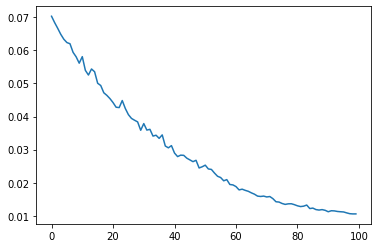

In [18]:
history = model.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Forecast training data

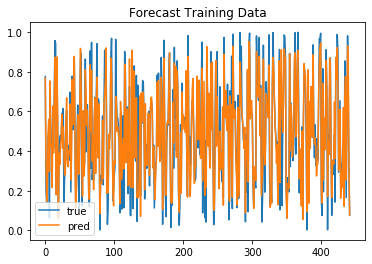

In [19]:
remainder_train_cdf = model.predict(input_data)
remainder_train = np.maximum(gev_dist.computeQuantile(remainder_train_cdf), 0)

plt.plot(output_data, label='true')
plt.plot(remainder_train_cdf, label='pred')
plt.legend()
plt.title('Forecast Training Data')
plt.show()

### Forecast test data

In [20]:
test_input = []
test_output = []

for i in range(num_train, remainder_series_cdf.shape[0]):
    test_input.append(np.squeeze(remainder_series_cdf[i - lag:i], axis=1))
    test_output.append(remainder_series_cdf[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (87, 50)
Test Output Data Shape: (87, 1)


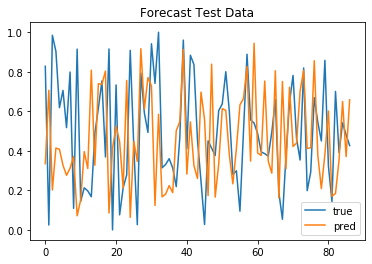

In [22]:
remainder_test_cdf = model.predict(test_input)
remainder_test = np.maximum(gev_dist.computeQuantile(remainder_test_cdf), 0)

plt.plot(test_output, label='true')
plt.plot(remainder_test_cdf, label='pred')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

## Forecasting Trend

### Model Architecture

In [23]:
lag = 50

model_trend = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation=None)
])

model_trend.build(input_shape=(None, lag))
model_trend.compile(
    optimizer=tf.optimizers.Adam(
        tf.optimizers.schedules.ExponentialDecay(
            0.01, 50, 0.9
        )
    ),
    loss=tf.losses.MeanSquaredError()
)

### Train the model

In [24]:
input_data = []
output_data = []

for i in range(lag + 1, train_trend_series.shape[0]):
    input_data.append(np.squeeze(train_trend_series[i - lag:i], axis=1))
    output_data.append(train_trend_series[i])
    
input_data = np.array(input_data)
output_data = np.array(output_data)
    
print(f'Input Data Shape: {input_data.shape}')
print(f'Output Data Shape: {output_data.shape}')

Input Data Shape: (442, 50)
Output Data Shape: (442, 1)


Epoch 1/100
14/14 [==============================] - 0s 855us/step - loss: 131.0693
Epoch 2/100
14/14 [==============================] - 0s 816us/step - loss: 72.1250
Epoch 3/100
14/14 [==============================] - 0s 972us/step - loss: 41.5029
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 32.7784
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 16.4158
Epoch 6/100
14/14 [==============================] - 0s 1ms/step - loss: 12.3308
Epoch 7/100
14/14 [==============================] - 0s 1ms/step - loss: 8.7994
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 8.6030
Epoch 9/100
14/14 [==============================] - 0s 1ms/step - loss: 8.6249
Epoch 10/100
14/14 [==============================] - 0s 2ms/step - loss: 10.1054
Epoch 11/100
14/14 [==============================] - 0s 1ms/step - loss: 6.0734
Epoch 12/100
14/14 [==============================] - 0s 2ms/step - loss: 6.0927
Epoch 13/100
14/14 [===

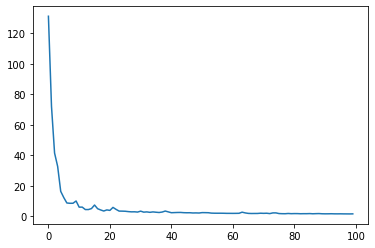

In [25]:
history = model_trend.fit(input_data, output_data, epochs=100)
plt.plot(history.history['loss'])

### Forecast training data

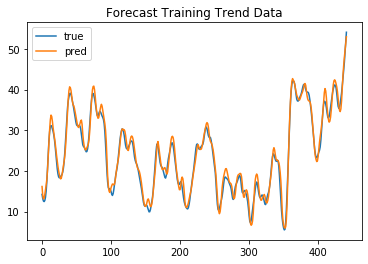

In [26]:
trend_train = model_trend.predict(input_data)

plt.plot(output_data, label='true')
plt.plot(trend_train, label='pred')
plt.legend()
plt.title('Forecast Training Trend Data')
plt.show()

### Forecast test data

In [27]:
test_input = []
test_output = []

for i in range(num_train, trend_series.shape[0]):
    test_input.append(np.squeeze(trend_series[i - lag:i], axis=1))
    test_output.append(trend_series[i])
    
test_input = np.array(test_input)
test_output = np.array(test_output)
    
print(f'Test Input Data Shape: {test_input.shape}')
print(f'Test Output Data Shape: {test_output.shape}')

Test Input Data Shape: (87, 50)
Test Output Data Shape: (87, 1)


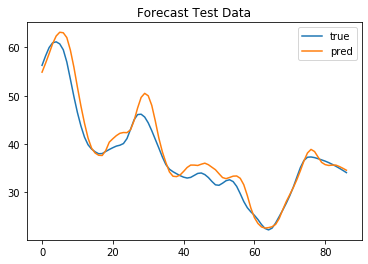

In [28]:
trend_test = model_trend.predict(test_input)

plt.plot(test_output, label='true')
plt.plot(trend_test, label='pred')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

## Forecasting Seasonality

### Forecast training data

In [29]:
seasonality_train = train_seasonality_series[lag + 1:]

### Forecast test data

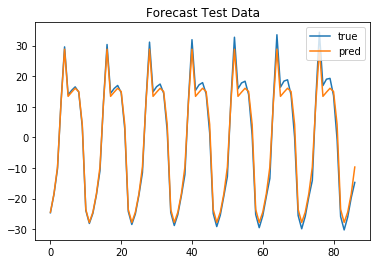

In [30]:
season_values = train_seasonality_series[-12:]
seasonality_test = np.zeros((test_seasonality_series.shape[0], 1))

for i in range(test_seasonality_series.shape[0]):
    seasonality_test[i] = season_values[i % 12]
    
plt.plot(test_seasonality_series, label='true')
plt.plot(seasonality_test, label='pred')
plt.legend()
plt.title('Forecast Test Data')
plt.show()

## Forecast Maximum Rainfall

In [31]:
print(remainder_train.shape, trend_train.shape, seasonality_train.shape)
print(remainder_test.shape, trend_test.shape, seasonality_test.shape)

(442, 1) (442, 1) (442, 1)
(87, 1) (87, 1) (87, 1)


### Forecast training data

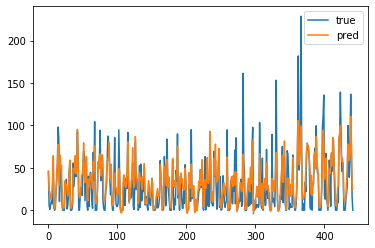

In [34]:
pred_train = remainder_train + trend_train + seasonality_train
true_train = month_max_series[:num_train][lag + 1:]

plt.plot(true_train, label='true')
plt.plot(pred_train, label='pred')
plt.legend()
plt.show()

### Forecast test data

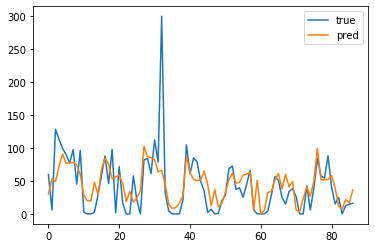

In [36]:
pred_test = remainder_test + trend_test + seasonality_test
true_test = month_max_series[num_train:]

plt.plot(true_test, label='true')
plt.plot(pred_test, label='pred')
plt.legend()
plt.show()